In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [5]:
load_df = pd.read_csv('../data/load_raw.csv')

load_df['Date'] = pd.to_datetime(load_df[['year','month','day']])
load_df.set_index('Date', inplace=True)

hour_cols = [f'h{i}' for i in range(1,25)]
load_df[hour_cols] = load_df[hour_cols].apply(pd.to_numeric, errors='coerce')

load_df['Daily_Load'] = load_df[hour_cols].sum(axis=1)

# Feature engineering (same as before)
load_df['DayOfWeek'] = load_df.index.dayofweek
load_df['Month'] = load_df.index.month
load_df['Is_Weekend'] = load_df['DayOfWeek'] >= 5

load_df['Lag_1'] = load_df['Daily_Load'].shift(1)
load_df['Lag_7'] = load_df['Daily_Load'].shift(7)
load_df['Lag_14'] = load_df['Daily_Load'].shift(14)

load_df['Rolling_7'] = load_df['Daily_Load'].rolling(7).mean()
load_df['Rolling_14'] = load_df['Daily_Load'].rolling(14).mean()

load_df.dropna(inplace=True)


In [6]:
features = [
    'DayOfWeek', 'Month', 'Is_Weekend',
    'Lag_1', 'Lag_7', 'Lag_14',
    'Rolling_7', 'Rolling_14'
]

X = load_df[features]
y = load_df['Daily_Load']


In [7]:
split_index = int(len(load_df) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]



In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)



,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [9]:
y_pred = lr.predict(X_test)



In [10]:
print(load_df.index.min())
print(load_df.index.max())


2004-01-01 00:00:00
2008-06-29 00:00:00


In [11]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Linear Regression Results")
print("MAE:", mae)
print("RMSE:", rmse)


Linear Regression Results
MAE: 785.6038852419376
RMSE: 1020.5097124557366


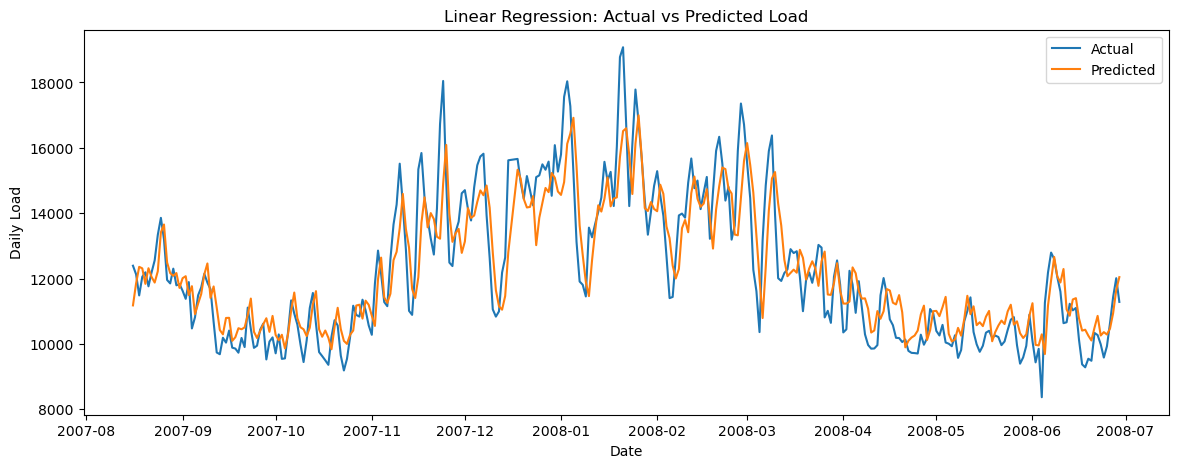

In [12]:
plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title("Linear Regression: Actual vs Predicted Load")
plt.xlabel("Date")
plt.ylabel("Daily Load")
plt.legend()
plt.show()


In [13]:
from sklearn.ensemble import RandomForestRegressor


In [14]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)


In [15]:
rf.fit(X_train, y_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
rf_pred = rf.predict(X_test)


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

print("Random Forest Results")
print("MAE:", rf_mae)
print("RMSE:", rf_rmse)


Random Forest Results
MAE: 659.6231612463929
RMSE: 887.6797493516351


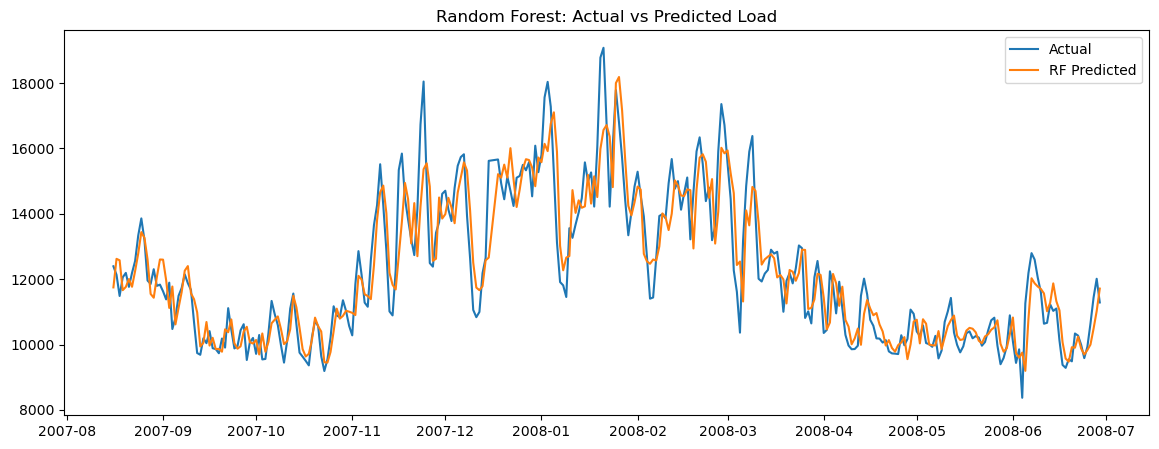

In [18]:
plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, rf_pred, label='RF Predicted')
plt.title("Random Forest: Actual vs Predicted Load")
plt.legend()
plt.show()


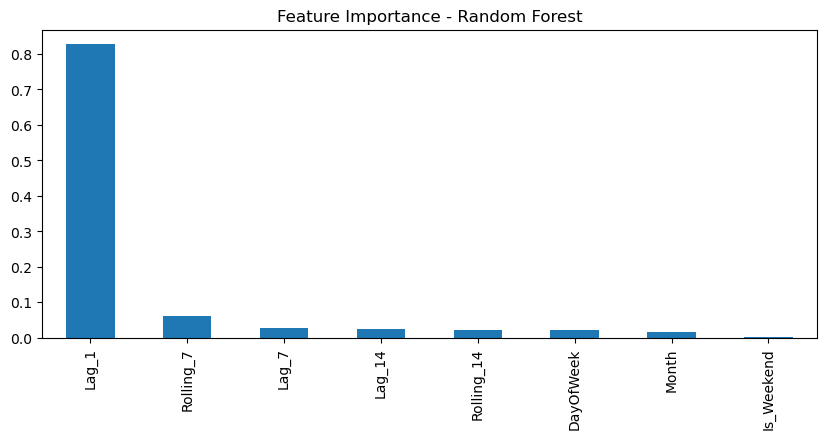

In [19]:
import pandas as pd

feature_importance = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

feature_importance.plot(kind='bar', figsize=(10,4))
plt.title("Feature Importance - Random Forest")
plt.show()


In [20]:
from xgboost import XGBRegressor


In [21]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)


In [22]:
xgb.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [23]:
xgb_pred = xgb.predict(X_test)


In [24]:
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

print("XGBoost Results")
print("MAE:", xgb_mae)
print("RMSE:", xgb_rmse)


XGBoost Results
MAE: 663.962440851735
RMSE: 899.508750861054


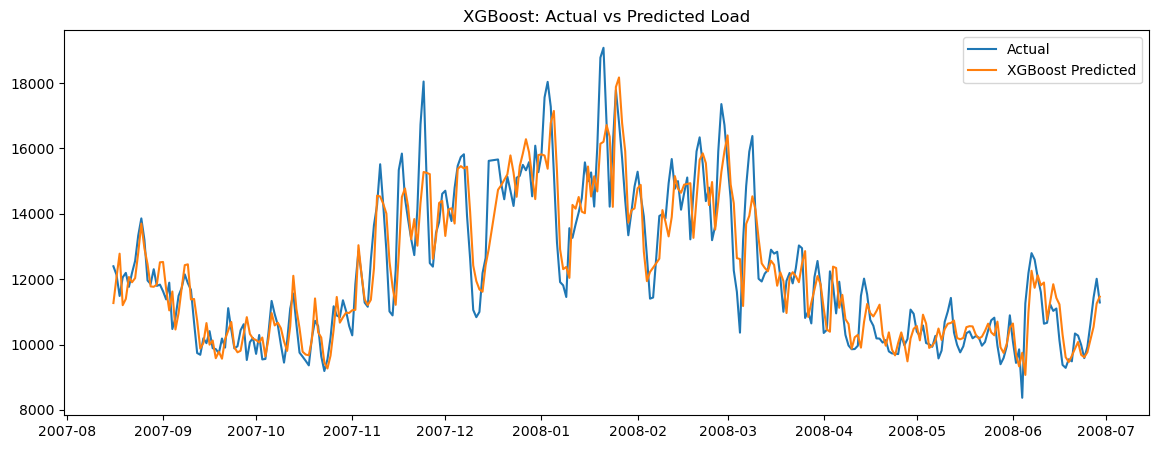

In [25]:
plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, xgb_pred, label='XGBoost Predicted')
plt.title("XGBoost: Actual vs Predicted Load")
plt.legend()
plt.show()


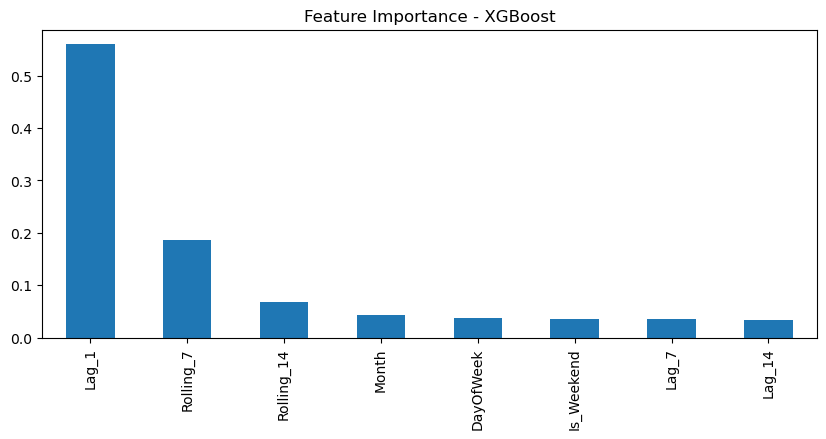

In [26]:
import pandas as pd

xgb_importance = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

xgb_importance.plot(kind='bar', figsize=(10,4))
plt.title("Feature Importance - XGBoost")
plt.show()


In [28]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'MAE': [mae, rf_mae, xgb_mae],
    'RMSE': [rmse, rf_rmse, xgb_rmse]
})

results


,Model,MAE,RMSE
0,Linear Regression,785.603885,1020.509712
1,Random Forest,659.623161,887.679749
2,XGBoost,663.962441,899.508751


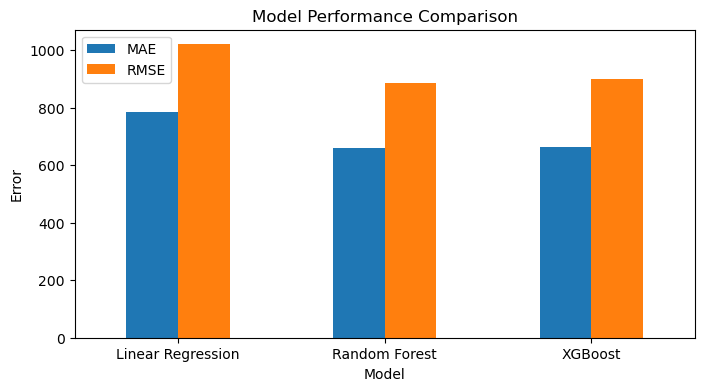

In [29]:
results.set_index('Model')[['MAE', 'RMSE']].plot(
    kind='bar',
    figsize=(8,4),
    title='Model Performance Comparison'
)

plt.ylabel("Error")
plt.xticks(rotation=0)
plt.show()


In [31]:
import pickle

# Save the trained Random Forest model
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)
